In this project, we will utilize pandas to analyze data, including value, risk, and return metrics, of the prominent 'FAANG' companies: Facebook, Apple, Amazon, Netflix, and Google. We will address several questions in this notebook:

1. What was the change in our stocks' prices over time?
2. What were the moving averages of our stocks?
3. What were the daily return averages of each stock?
4. What was the correlation between the daily returns of different stocks?
5. How much value do we put at risk by investing in a particular stock?
6. How can we attempt to predict future 'FAANG' stock behavior?

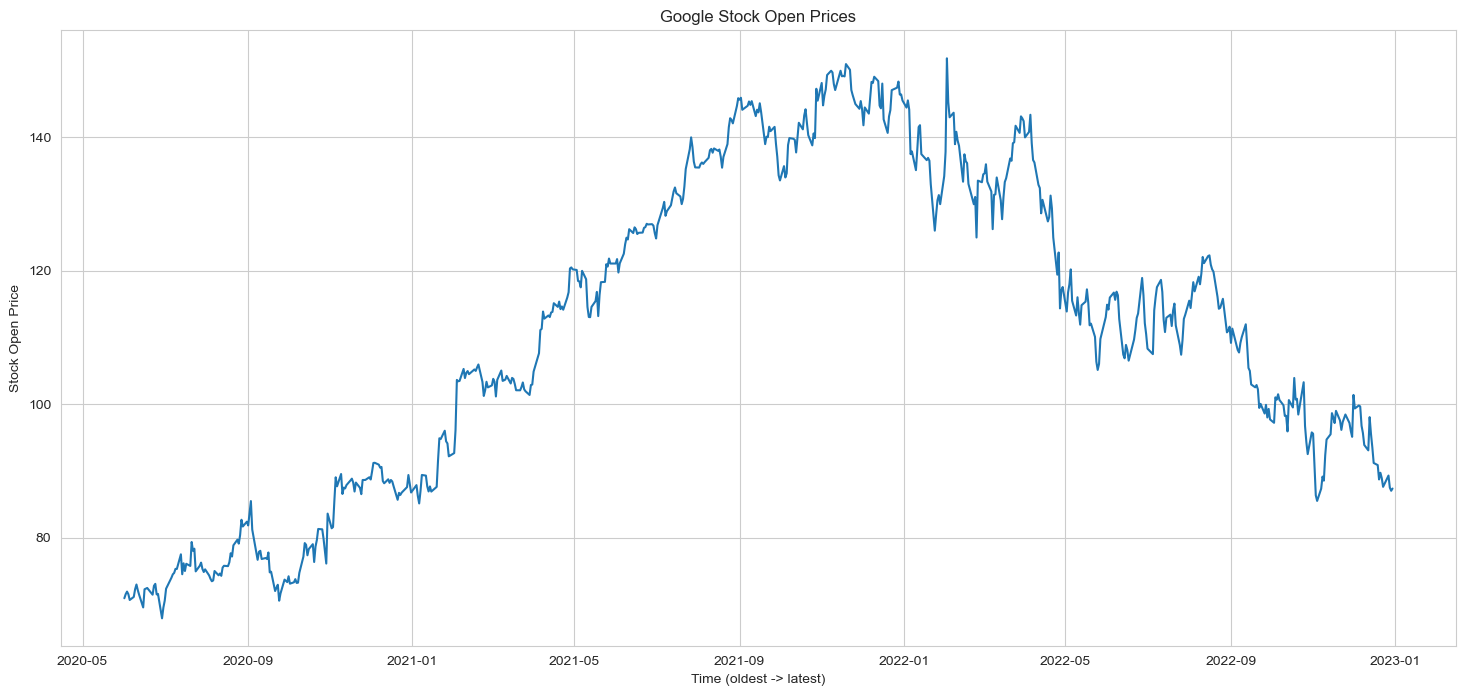

Epoch 1/100
19/19 [==============================] - 4s 56ms/step - loss: 0.0760
Epoch 2/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0138
Epoch 3/100
19/19 [==============================] - 1s 55ms/step - loss: 0.0106
Epoch 4/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0096
Epoch 5/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0100
Epoch 6/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0098
Epoch 7/100
19/19 [==============================] - 1s 55ms/step - loss: 0.0090
Epoch 8/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0082
Epoch 9/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0090
Epoch 10/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0098
Epoch 11/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0082
Epoch 12/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0076
Epoch 13/100
19/19 [=====

In [95]:
## Based on New findings, LSTM will be revised as fllwoing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

dataset_train = ticker_data['GOOG'].loc[ticker_data['GOOG'].index <= '2022-12-31']

#print(dataset_train.head())

#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values
training_set.shape
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape
y_train.shape

## Data reshaping

X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

## Create LSTM model and fit the data

regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Model Fit
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)



4/4 [==============================] - 1s 15ms/step


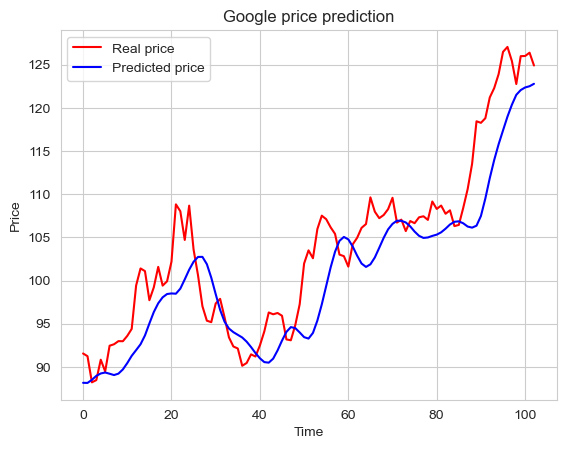

In [96]:
## continue to predict the stock price

## Model evaluation
dataset_test = ticker_data['GOOG'].loc[ticker_data['GOOG'].index > '2022-12-31']
dataset_test.head()
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)
len(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_test.shape

## prediction

predicted_stock_price = regressor.predict(X_test)
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()




4/4 [==============================] - 0s 16ms/step
Root Mean Squared Error: 4.9419


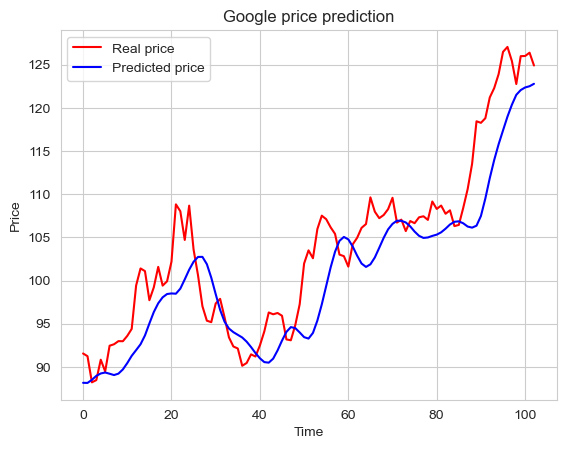

In [97]:
## RESULTS OF ABOVE STUDY
from sklearn.metrics import mean_squared_error

# The rest of your code is above

## prediction
predicted_stock_price = regressor.predict(X_test)

#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## Comparison of different approaches

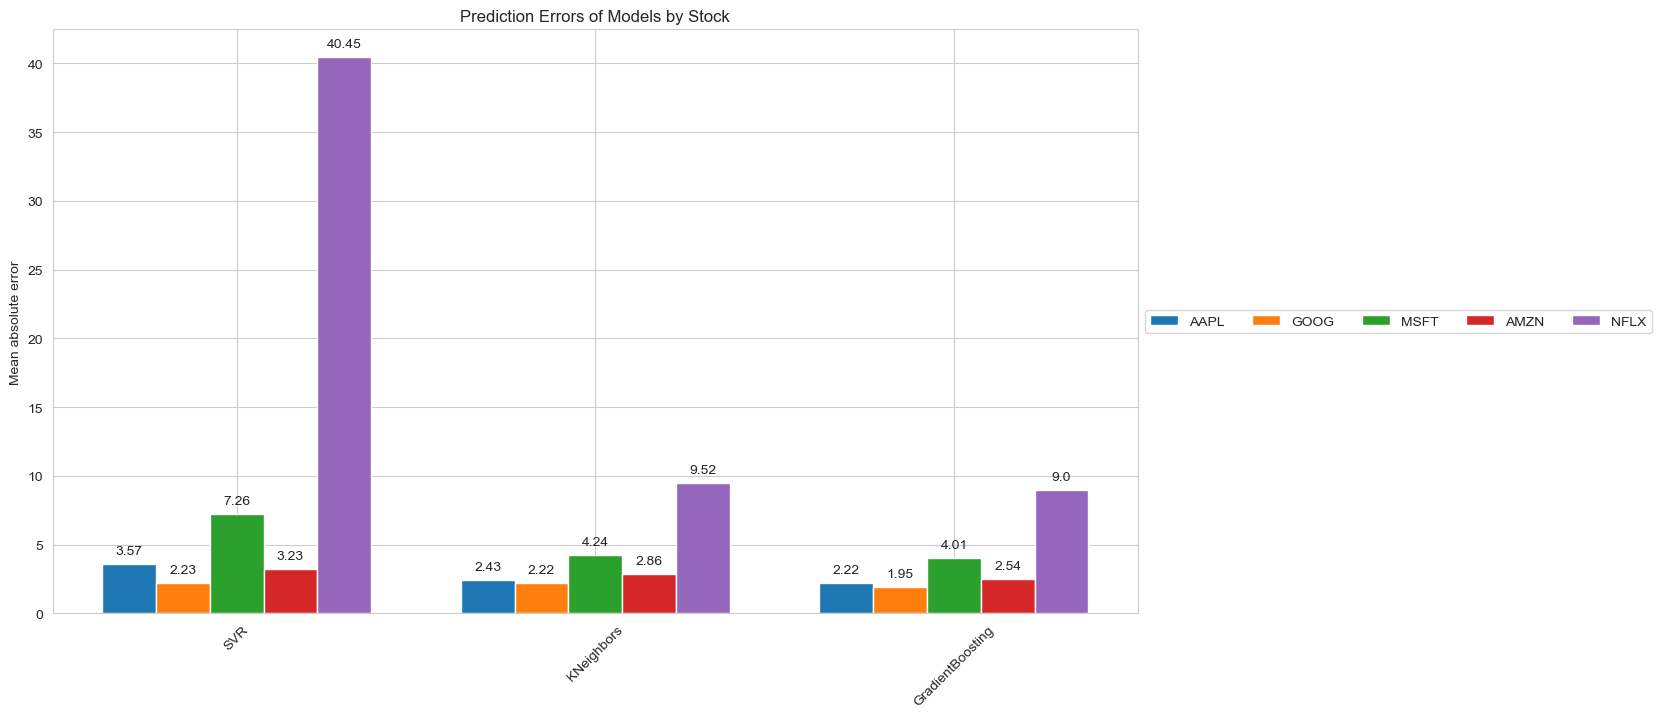

In [98]:
# Define colors for each ticker
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NFLX']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Less intense colors

# Create a color dictionary
color_dict = dict(zip(tickers, colors))

# Convert the results dictionary to a pandas DataFrame
df_results = pd.DataFrame(MAE_results)

# Transpose the DataFrame so that the models are the columns and tickers are the index
df_results = df_results.T

# Define the positions for the bars
bar_width = 0.15
indices = np.arange(len(df_results.columns))

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(14, 8))  # Increase the figure size

# For each model, create a bar plot at a different position
for i, (ticker, accuracies) in enumerate(df_results.iterrows()):
    bars = ax.bar(indices + i*bar_width, accuracies, bar_width, label=ticker, color=color_dict[ticker])
    
    # Add labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# Label the x-axis with the ticker symbols
ax.set_xticks(indices + bar_width * (len(df_results.index)-1) / 2)
ax.set_xticklabels(df_results.columns, rotation=45)  # Rotate the x-axis labels

# Add the legend and labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=len(tickers))  # Move the legend to the right side
plt.ylabel('Mean absolute error')
plt.title('Prediction Errors of Models by Stock')
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom of the plot to prevent overlap
plt.show()




From the correlation heatmap, it becomes clear that Microsoft and Amazon share a stronger correlation, and in general
Microsoft maintains a strongest pairwise aggregate correlations compared to the rest of the 'FAANG' companies. Though perhaps expected, it is noteworthy that all five companies pairwise have moderate to strong positive correlation.

## Determining Value from Risk vs. Expected Return
Now we address the question of risk in buying stocks to compare these five companies.

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define a function to plot stock data
def plot_stock_data(df, ticker):
    plt.figure(figsize=(15, 8))
    df['Adj Close'].plot()
    plt.title(f'{ticker} - Adj Close')
    plt.show()

    plt.figure(figsize=(15, 8))
    df['Volume'].plot()
    plt.title(f'{ticker} - Volume')
    plt.show()

    df[['Adj Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(figsize=(15, 8))
    plt.title(f'{ticker} - Moving Averages')
    plt.show()

    plt.figure(figsize=(15, 8))
    sns.histplot(df['Daily Return'].dropna(), bins=100, color='red')
    plt.title(f'{ticker} - Daily Return')
    plt.show()

# Define a function to compute and plot correlations
def compute_and_plot_correlations(df):
    correlation_matrix = df.corr()

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

    plt.title('Correlation Matrix of Daily Returns', fontsize=15)
    plt.show()

# Define a function to train and evaluate models
def train_and_evaluate_models(df, ticker):
    accuracy_results = {}

    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    models = {
        'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2,
                                               min_samples_leaf=1, max_depth=10, bootstrap=True),
        'SVR': SVR(kernel='rbf'),
        'KNeighbors': KNeighborsRegressor(n_neighbors=2),
        'GradientBoosting': GradientBoostingRegressor(),
        'LSTM': Sequential([
            LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
            LSTM(50),
            Dense(1)
        ])
    }

    for model_name, model in models.items():
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        accuracy = round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)
        accuracy_results[model_name] = accuracy

    return accuracy



From this plot we can see that Microsoft has the highest expected return and the lowest risk -- a sign that it is the best stock to buy at the moment. With its overhaul of its cloud computing sectors and high-profile acquisitions, Microsoft stock is a clear winner here. Netflix's performance is more concerning as it has virtually zero positive expected return along with the highest risk.

We want to model an additional value-at-risk metric in order to assess the value at each risk confidence interval for these 5 companies. Let's try this two ways: bootstrapping and using Monte Carlo-GBM, with Google.

In [100]:
rets_compr.head()

,AAPL,GOOG,MSFT,AMZN,NFLX
Date,,,,,
2020-06-01,NaN,NaN,NaN,NaN,NaN
2020-06-02,0.004629,0.005168,0.011377,0.000554,0.003263
2020-06-03,0.005505,-0.001973,0.002433,0.002423,-0.012497
2020-06-04,-0.008612,-0.016848,-0.013163,-0.007182,-0.018106
2020-06-05,0.028481,0.018560,0.023398,0.009103,0.012719


In [101]:
rets_compr['GOOG'].quantile(q=0.05)


-0.030845376037947823

In [102]:
rets_compr['GOOG'].quantile(q=0.01)



-0.05065555772671154

From the empirical quantiles given for both confience intervals, we know that the worst possible loss will not exceed 2.65 percent with 95% confidence and 5.04 percent with 99% confidence.

## Predicting Future Risk and Value of Stocks
We run the Monte Carlo Method on the GBM model to assess the stability and predict the future risk of our stocks. For this component, I'll be analyzing Google's stock.

In [103]:
days = 365

#delta t
dt = 1/365

mu = rets_compr.mean()['GOOG']

sigma = rets_compr.std()['GOOG']


def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        
        drift[x] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
        
    return price


We’re going to run 100 Monte Carlo simulations of Google stocks. Here's the stock's opening values again.



In [104]:
GOOG.head()

NameError: name 'GOOG' is not defined

Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

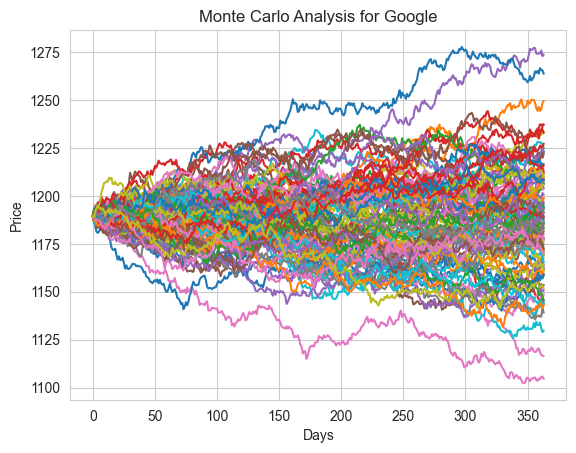

In [ ]:
start_price = 1189.39 #Taken from above

for run in range(1,100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Google')

Text(0.5, 1.0, 'Final price distribution for Google Stock after 364 days')

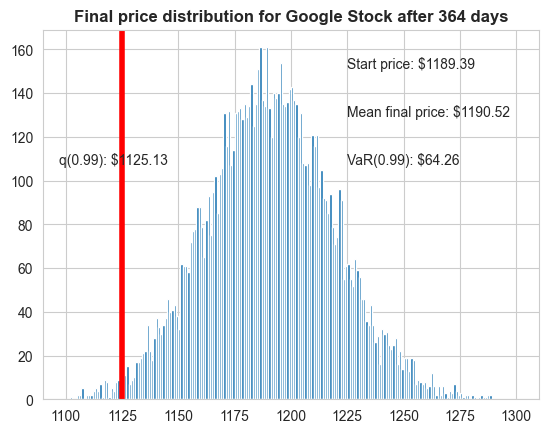

In [ ]:
runs = 10000

simulations = np.zeros(runs)

for run in range(1,runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

plt.hist(simulations,bins=200,range = [1100,1300])

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)

plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))

plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Google Stock after %s days" %days, weight='bold')

Based off the histogram, we conclude that Google's stock price is very stable (only a $0.11 difference between start and mean final price). The value-at-risk of our investment is $46.42 for maximum low price of $1142.97 with 99% confidence, which is approximately a 3.9% risk compared to the 6.5% we achieved via bootstrapping. 